In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
# NOTE: change destination folder of dataset to suit.
sentiment140_data = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv", 
                                encoding="ISO-8859-1", header=None, names=["target","id","date","flag","user","text"])

# Data Exploration

In [4]:
sentiment140_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
sentiment140_data.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
sentiment140_data.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [7]:
len(sentiment140_data)

1600000

In [8]:
sentiment140_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
np.sum(sentiment140_data.isnull().any(axis=1))

0

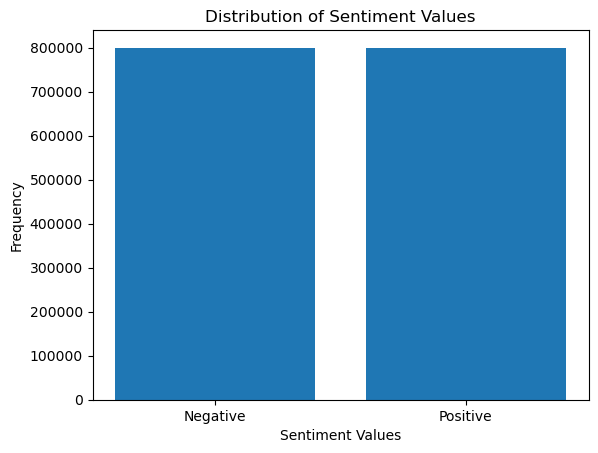

In [10]:
# Bar chart to check for data imbalance.
sentiments = ["Negative", "Positive"]
value_counts = sentiment140_data["target"].value_counts()
x_positions = [0, 1]
plt.bar(x_positions, value_counts, tick_label=sentiments)
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.show()

# Data Preprocessing

## Sample Dataset

In [11]:
data = sentiment140_data.sample(frac=0.1, random_state=42)

In [12]:
len(data)

160000

## Drop columns that arent needed

In [13]:
data = data.drop(["id","date","flag","user"], axis=1)

In [14]:
data.head()

,target,text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


## Data Cleaning

In [15]:
nltk.download('stopwords', quiet=True)

True

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_RE, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
data["text"] = data["text"].apply(lambda x: preprocess(x))
data.head()

,target,text
541200,0,ahhh hope ok
750,0,cool tweet apps razr 2
766711,0,know family drama lame hey next time u hang ki...
285055,0,school email open geography stuff revise stupi...
705995,0,upper airways problem


## Train Test Split

In [19]:
X = data["text"]
y = data["target"]

TRAIN_SIZE = 0.7
train, test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)

X_train = train["text"]
X_test = test["text"]
y_train = train["target"]
y_test = test["target"]

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(111999,)
(48001,)
(111999,)
(48001,)


In [21]:
X.head()

541200                                         ahhh hope ok
750                                  cool tweet apps razr 2
766711    know family drama lame hey next time u hang ki...
285055    school email open geography stuff revise stupi...
705995                                upper airways problem
Name: text, dtype: object

In [22]:
y.head()

541200    0
750       0
766711    0
285055    0
705995    0
Name: target, dtype: int64

# Feature Extraction

## TF-IDF

In [23]:
NGRAM_RANGE = (1,2)
#MAX_FEATURES = 50000
tfidf = TfidfVectorizer(ngram_range=NGRAM_RANGE)

In [24]:
tfidf.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [25]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Word Embedding

### Word Tokenization for Embedding

In [26]:
regexp = RegexpTokenizer(r'\w+')
X_train_tk = X_train.apply(regexp.tokenize)
X_train_tk.head()

229771                                                 [bad]
1193312    [played, cute, nephew, today, gonna, go, dinne...
1468679    [could, sunny, everyday, rain, cold, weather, ...
1195724                         [n, dont, worry, back, soon]
794333                         [nooooo, leave, 5, 30, today]
Name: text, dtype: object

In [27]:
len(X_train_tk)

111999

### Word2Vec

In [28]:
VECTOR_SIZE = 300
EPOCHS = 16
word2Vec = gensim.models.Word2Vec(X_train_tk, min_count=5, vector_size=VECTOR_SIZE, window=5, workers=8, sg=1, epochs=EPOCHS, seed=42)

In [29]:
word2Vec.wv.most_similar('weather', topn=5)

[('cloudy', 0.5242199301719666),
 ('humid', 0.5185630321502686),
 ('rainy', 0.5179226398468018),
 ('muggy', 0.5162774920463562),
 ('gloomy', 0.5143342614173889)]

In [30]:
word2Vec.save("word2Vec.model")

In [31]:
word2Vec = Word2Vec.load("word2Vec.model")

### Label Encoding

In [32]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.tolist())
y_test = le.transform(y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Machine Learning Models

## Support Vector Machine

In [ ]:
#def grid_search(model, parameters, X_train, Y_train):
#    #Doing a grid
#    grid = GridSearchCV(estimator=model,
#                        param_grid = parameters,
#                        cv = 2, verbose=2, scoring='roc_auc')
#    #Fitting the grid 
#    grid.fit(X_train,Y_train)
#    print()
#    print()
#    
#    # Best model found using grid search
#    optimal_model = grid.best_estimator_
#    print('Best parameters are: ')
#    print( grid.best_params_)
#    
#    return optimal_model

In [ ]:
#%%time
## Tuning the hyperparameters
#parameters ={
#    "C":[0.1,1,10],
#    "kernel":['linear', 'rbf', 'sigmoid'],
#    "gamma":['scale', 'auto']
#}
#
#
#
#svm_optimal = grid_search(svm.SVC(probability=True), parameters,X_train, Y_train)

In [35]:
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train.ravel())

LinearSVC()

## Long Short-Term Memory Network

### Tokenization and Padding

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 77822


In [37]:
MAX_SEQUENCE_LENGTH = 100
X_train_tk = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_test_tk = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

print(X_train_tk.shape)
print(X_test_tk.shape)

(111999, 100)
(48001, 100)


### Model

In [54]:
embedding_matrix = np.zeros((vocab_size, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2Vec.wv:
        embedding_matrix[i] = word2Vec.wv[word]
print(embedding_matrix.shape)

(77822, 300)


In [ ]:
def LSTM_Model(embedding_layer):
    model = Sequential(name="Full_LSTM_Model")
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Conv1D(100,5,activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    print(model.summary())

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        X_train_tk, y_train,
        batch_size=1024,
        epochs=8,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1,
    )
    
    return (model, history)

In [ ]:
embedding_layer = Embedding(input_dim = vocab_size,
                            output_dim = VECTOR_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

lstm_model, lstm_history = LSTM_Model(embedding_layer)

In [ ]:
lstm_model.save("LSTM_model.keras")

In [38]:
lstm_model = tf.keras.models.load_model("LSTM_model.keras")

# Performance Evaluation Metrics

In [39]:
y_pred_svm = svm_model.predict(X_test_tfidf)

In [40]:
y_pred_lstm = lstm_model.predict(X_test_tk)
y_pred_lstm = np.where(y_pred_lstm>=0.5, 1, 0)

1501/1501 [==============================] - 686s 454ms/step


## Accuracy

In [41]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM ACCURACY:",accuracy_svm)

SVM ACCURACY: 0.7652965563217433


In [42]:
score_lstm = lstm_model.evaluate(X_test_tk, y_test, batch_size=1024)
print("LSTM ACCURACY:", score_lstm[1])
print("LSTM LOSS:", score_lstm[0])

47/47 [==============================] - 435s 9s/step - loss: 0.4797 - accuracy: 0.7668
LSTM ACCURACY: 0.7668381929397583
LSTM LOSS: 0.4797443449497223


## Classification Scores

In [43]:
print("----- SVM CLASSIFICATION REPORT -----\n", 
      classification_report(y_test, y_pred_svm, target_names=['Negative','Positive']))

----- SVM CLASSIFICATION REPORT -----
               precision    recall  f1-score   support

    Negative       0.76      0.77      0.76     23853
    Positive       0.77      0.76      0.77     24148

    accuracy                           0.77     48001
   macro avg       0.77      0.77      0.77     48001
weighted avg       0.77      0.77      0.77     48001



In [44]:
print("----- LSTM CLASSIFICATION REPORT -----\n", 
      classification_report(y_test, y_pred_lstm, target_names=['Negative','Positive']))

----- LSTM CLASSIFICATION REPORT -----
               precision    recall  f1-score   support

    Negative       0.76      0.77      0.77     23853
    Positive       0.77      0.76      0.77     24148

    accuracy                           0.77     48001
   macro avg       0.77      0.77      0.77     48001
weighted avg       0.77      0.77      0.77     48001



## Confusion Matrix

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

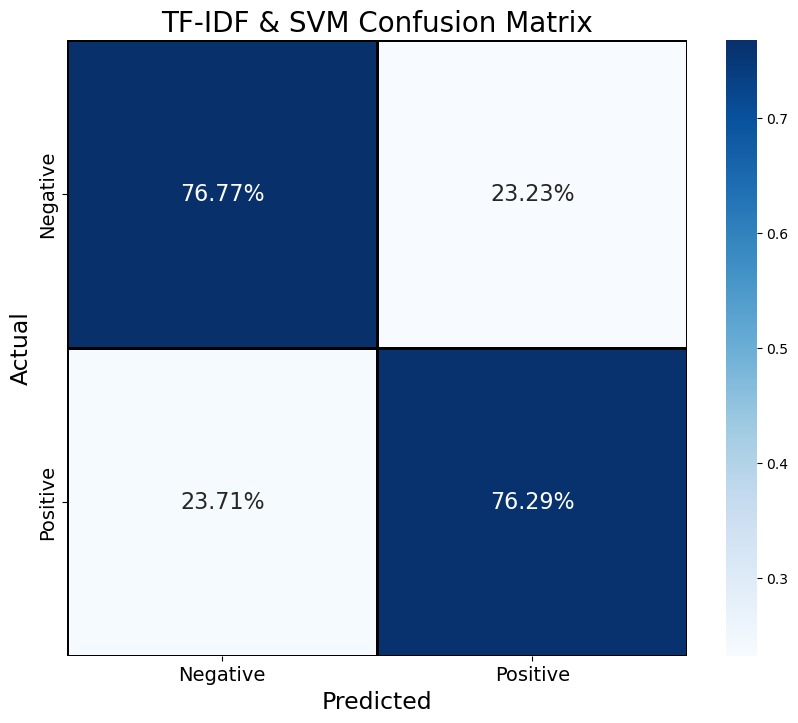

In [45]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(cm_svm, annot=True, fmt=".2%", cmap='Blues',
            xticklabels = ['Negative','Positive'], 
            yticklabels = ['Negative','Positive'],
            annot_kws={"size": 16},
            linecolor='black', linewidth=2 )
plt.title("TF-IDF & SVM Confusion Matrix", fontsize=20)
plt.xlabel("Predicted", fontsize=17)
plt.ylabel("Actual", fontsize=17)

heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_xticklabels(), size=14)

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

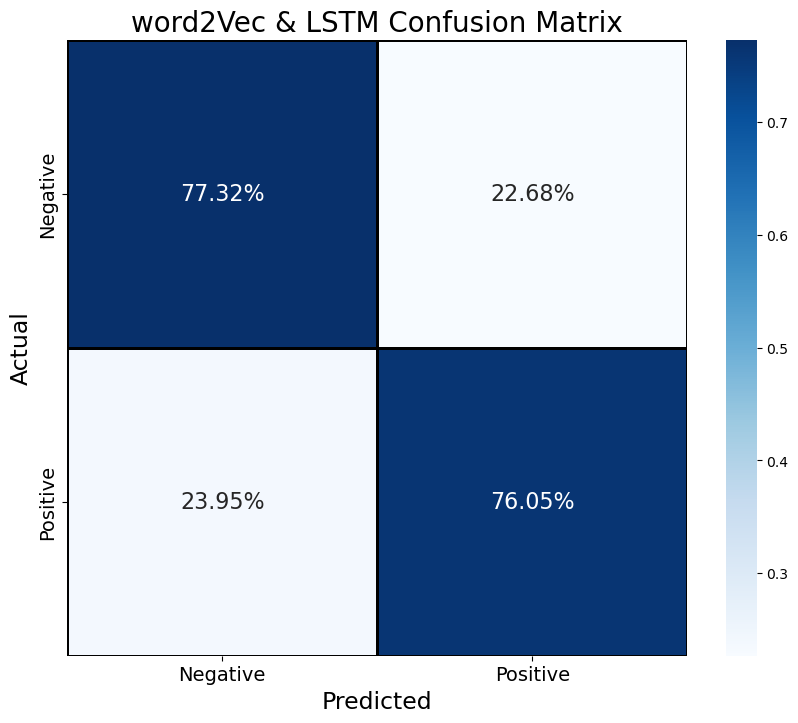

In [46]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
cm_lstm = cm_lstm.astype('float') / cm_lstm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(cm_lstm, annot=True, fmt=".2%", cmap='Blues',
            xticklabels = ['Negative','Positive'], 
            yticklabels = ['Negative','Positive'],
            annot_kws={"size": 16},
            linecolor='black', linewidth=2 )
plt.title("word2Vec & LSTM Confusion Matrix", fontsize=20)
plt.xlabel("Predicted", fontsize=17)
plt.ylabel("Actual", fontsize=17)

heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_xticklabels(), size=14)

## Example Tweets

In [47]:
def get_sentiment(sentiment_value):
    if sentiment_value >= 0.5:
        return "Positive"
    else:
        return "Negative"

In [48]:
def predict_sentiment_svm(tweet):
    X_tweet = tfidf.transform([tweet])
    sentiment_score = svm_model.predict(X_tweet)
    return get_sentiment(sentiment_score)

In [49]:
def predict_sentiment_lstm(tweet):
    X_tweet = pad_sequences(tokenizer.texts_to_sequences([tweet]), maxlen=MAX_SEQUENCE_LENGTH)
    sentiment_score = lstm_model.predict([X_tweet])[0]
    return get_sentiment(sentiment_score)

In [50]:
predict_sentiment_svm("I love csci218")

'Positive'

In [51]:
predict_sentiment_lstm("I love csci218")

1/1 [==============================] - 7s 7s/step


'Positive'

In [52]:
predict_sentiment_svm("I hate jazz")

'Negative'

In [53]:
predict_sentiment_lstm("I hate jazz")

1/1 [==============================] - 0s 221ms/step


'Negative'

### Word2Vec Word Pair Plot - 'happy' & 'sad'

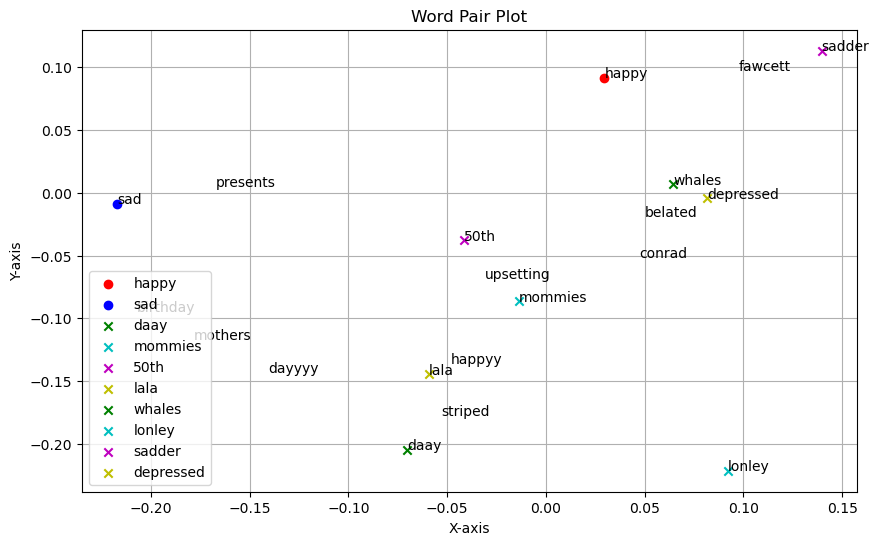

In [55]:
word1 = "happy"
word2 = "sad"
vec1 = word2Vec.wv[word1]
vec2 = word2Vec.wv[word2]

similar_words1 = [word for word, _ in word2Vec.wv.most_similar(word1)]
similar_words2 = [word for word, _ in word2Vec.wv.most_similar(word2)]

plt.figure(figsize=(10, 6))
plt.scatter(vec1[0], vec1[1], c='r', marker='o', label=word1)
plt.scatter(vec2[0], vec2[1], c='b', marker='o', label=word2)

for word, color in zip(similar_words1, ['g', 'c', 'm', 'y']):
    word_vector = word2Vec.wv[word]
    plt.scatter(word_vector[0], word_vector[1], c=color, marker='x', label=word)

for word, color in zip(similar_words2, ['g', 'c', 'm', 'y']):
    word_vector = word2Vec.wv[word]
    plt.scatter(word_vector[0], word_vector[1], c=color, marker='x', label=word)

for word in [word1, word2] + similar_words1 + similar_words2:
    word_vector = word2Vec.wv[word]
    plt.annotate(word, (word_vector[0], word_vector[1]))

plt.legend()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Word Pair Plot")
plt.grid(True)
plt.show()